In [1]:
%matplotlib inline
import glob
import os
import matplotlib.pyplot as plt

import artm

# Адрес, по которому находятся данные
BATCH_ADRESS = 'batches_news_ria'

# Вывод версии BigARTM
print(artm.version())

0.10.0


In [2]:
# Установка адреса, по которому находятся данные
batch_vectorizer = artm.BatchVectorizer(
    data_path=BATCH_ADRESS, data_format='batches'
)

In [3]:
# Пересоздание словаря для модели и сохранение его в файл

# Устанавливается название словаря для модели
dictionary_address = BATCH_ADRESS + '/dictionary.dict'

# Инициализация словоря для модели
dictionary = artm.Dictionary()

# Удаление словаря, оставшегося после предыдущих запусков
if os.path.isfile(dictionary_address):
    os.remove(dictionary_address)
    
# Сохранение словаря в файл
dictionary.gather(data_path=batch_vectorizer.data_path)
dictionary.save(dictionary_path=dictionary_address)

# Загрузка словаря из файла
dictionary.load(dictionary_path=dictionary_address)
print(
    '{:>7}'.format(dictionary.__dict__['_master'].get_info().dictionary[0].num_entries),
    "- количество слов в словаре"
)


# Фильтрация

# Убираются редкие слова по всей коллекции
# Слово встречается во всей коллекции больше чем n раз
dictionary.filter(min_tf=10)
print(
    '{:>7}'.format(dictionary.__dict__['_master'].get_info().dictionary[0].num_entries),
    "- количество слов в словаре после фильтрации по min_tf", 
)

# Убираются частые слова по всей коллекции
# Слово встречается во всей коллекции меньше чем n раз
dictionary.filter(max_tf=2000)
print(
    '{:>7}'.format(dictionary.__dict__['_master'].get_info().dictionary[0].num_entries),
    "- количество слов в словаре после фильтрации по max_tf", 
)

# Убираются слова, которые попадаются меньше чем в n процентов документов
dictionary.filter(min_df_rate=0.0001)
print(
    '{:>7}'.format(dictionary.__dict__['_master'].get_info().dictionary[0].num_entries),
    "- количество слов в словаре после фильтрации по min_df_rate", 
)

# Убираются слова, которые попадаются больше чем в n процентов документов
dictionary.filter(max_df_rate=0.6)
print(
    '{:>7}'.format(dictionary.__dict__['_master'].get_info().dictionary[0].num_entries),
    "- количество слов в словаре после фильтрации по max_df_rate", 
)

  88657 - количество слов в словаре
  21068 - количество слов в словаре после фильтрации по min_tf
  20685 - количество слов в словаре после фильтрации по max_tf
  20470 - количество слов в словаре после фильтрации по min_df_rate
  20470 - количество слов в словаре после фильтрации по max_df_rate


In [4]:
def new_default_model(topic_count, dictionary):
    
    # Создание модели
    model_artm = artm.ARTM(
        # Названия тем
        topic_names=['topic_{0:0>3}'.format(i) for i in range(topic_count)], 
        # Разрешается хранить матрицу theta в памяти
        cache_theta=True,
        # Фиксация seed для воспроизвдимости результатов
        seed=-1,
        # Настройка - сколько раз обрабатывать каждый документ
        num_document_passes=1,
        # Модальности
        #class_ids={'text': 1.0},
    )

    # Инициализация модели
    model_artm.initialize(dictionary=dictionary)

    # Установка отслеживаемых параметров
    # Перплексия (чем она меньше тем лучше)
    model_artm.scores.add(artm.PerplexityScore(name='PerplexityScore'))
    # Разреженность матрицы Phi (доля почти нулевых значений)
    model_artm.scores.add(artm.SparsityPhiScore(name='SparsityPhiScore'))
    # Разреженность матрицы Theta (доля почти нулевых значений)
    model_artm.scores.add(artm.SparsityThetaScore(name='SparsityThetaScore'))
    # Анализ самых используемых слов по темам
    model_artm.scores.add(artm.TopTokensScore(name='TopTokensScore', num_tokens=10))
    # Анализ ядра тем на контраст и чистоту
    model_artm.scores.add(artm.TopicKernelScore(name='TopicKernelScore'))
    #model_artm.scores.add(artm.TopicKernelScore(name='TopicKernelScore', probability_mass_threshold=0.3))
    
    return model_artm

In [5]:
def model_print_results(model_artm):
    
    # Графики
    
    fig = plt.figure(figsize=(15, 20))

    ax = plt.subplot2grid((4,3), (0,0), colspan = 1, rowspan = 1,  fig=fig)
    ax.plot(model_artm.score_tracker["PerplexityScore"].value, color='tab:blue')
    ax.set_xlabel('Iterations count')
    ax.set_ylabel('PerplexityScore')
    ax.grid(True)

    ax = plt.subplot2grid((4,3), (0,1), colspan = 1, rowspan = 1,  fig=fig)
    ax.plot(model_artm.score_tracker["SparsityPhiScore"].value, color='tab:blue')
    ax.set_xlabel('Iterations count')
    ax.set_ylabel('SparsityPhiScore')
    ax.grid(True)
    ax.set_ylim([0,1])

    ax = plt.subplot2grid((4,3), (0,2), colspan = 1, rowspan = 1,  fig=fig)
    ax.plot(model_artm.score_tracker["SparsityThetaScore"].value, color='tab:blue')
    ax.set_xlabel('Iterations count')
    ax.set_ylabel('SparsityThetaScore')
    ax.grid(True)
    ax.set_ylim([0,1])


    ax = plt.subplot2grid((4,3), (1,0), colspan = 1, rowspan = 1,  fig=fig)
    ax.plot(model_artm.score_tracker["TopicKernelScore"].average_contrast, color='tab:blue')
    ax.set_xlabel('Iterations count')
    ax.set_ylabel('TopicKernelScore_average_contrast')
    ax.grid(True)
    ax.set_ylim([0,1])

    ax = plt.subplot2grid((4,3), (1,1), colspan = 2, rowspan = 1,  fig=fig)
    my_contrast_dictionary = model_artm.score_tracker['TopicKernelScore'].last_contrast
    ax.bar(my_contrast_dictionary.keys(), my_contrast_dictionary.values(), 0.5, color='tab:blue')
    #ax.set_xlabel('//')
    #ax.set_ylabel('//')
    ax.grid(True)
    ax.tick_params(axis='x', rotation=90)
    ax.set_ylim([0,1])


    ax = plt.subplot2grid((4,3), (2,0), colspan = 1, rowspan = 1,  fig=fig)
    ax.plot(model_artm.score_tracker['TopicKernelScore'].average_purity, color='tab:blue')
    ax.set_xlabel('Iterations count')
    ax.set_ylabel('TopicKernelScore_average_purity')
    ax.grid(True)
    ax.set_ylim([0,1])

    ax = plt.subplot2grid((4,3), (2,1), colspan = 2, rowspan = 1,  fig=fig)
    my_purity_dictionary = model_artm.score_tracker['TopicKernelScore'].last_purity
    ax.bar(my_purity_dictionary.keys(), my_purity_dictionary.values(), 0.5, color='tab:blue')
    #ax.set_xlabel('//')
    #ax.set_ylabel('//')
    ax.grid(True)
    ax.tick_params(axis='x', rotation=90)
    ax.set_ylim([0,1])


    ax = plt.subplot2grid((4,3), (3,0), colspan = 1, rowspan = 1,  fig=fig)
    my_average_size = model_artm.score_tracker['TopicKernelScore'].average_size
    ax.plot(my_average_size, color='tab:blue')
    ax.plot([model_artm.phi_.shape[0]/model_artm.num_topics for i in range(len(my_average_size))], color='tab:orange')
    ax.set_xlabel('Iterations count')
    ax.set_ylabel('TopicKernelScore_average_size')
    ax.grid(True)
    ax.set_ylim([0,ax.get_ylim()[1]])

    ax = plt.subplot2grid((4,3), (3,1), colspan = 2, rowspan = 1,  fig=fig)
    my_size_dictionary = model_artm.score_tracker['TopicKernelScore'].last_size
    ax.bar(my_size_dictionary.keys(), my_size_dictionary.values(), 0.5, color='tab:blue')
    ax.plot([model_artm.phi_.shape[0]/model_artm.num_topics for i in range(model_artm.num_topics)], color='tab:orange')
    #ax.set_xlabel('//')
    #ax.set_ylabel('//')
    ax.grid(True)
    ax.tick_params(axis='x', rotation=90)

    plt.show()
    
    
    # Конечные значения
    
    print("PerplexityScore:", model_artm.score_tracker["PerplexityScore"].last_value)
    print("SparsityPhiScore:", model_artm.score_tracker["SparsityPhiScore"].last_value)
    print("SparsityThetaScore:", model_artm.score_tracker["SparsityThetaScore"].last_value)
    print()
    print("TopicKernelScore_average_contrast:", model_artm.score_tracker["TopicKernelScore"].last_average_contrast)
    print("TopicKernelScore_average_purity:", model_artm.score_tracker['TopicKernelScore'].last_average_purity)
    print("TopicKernelScore_average_size:", model_artm.score_tracker['TopicKernelScore'].last_average_size)
    
    print()
    
    
    # Главные слова в темах
    
    print("TopTokensScore:")
    topic_list = list(model_artm.score_tracker['TopTokensScore'].last_tokens.keys())
    for topic_name in topic_list:
        print(topic_name + ': ', end='')
        for token_name in model_artm.score_tracker['TopTokensScore'].last_tokens[topic_name]:
            print(token_name, end=' ')
        print()

In [6]:
params = {
    'topic_count': 150,
    'num_collection_passes': 40,
    'SparsePhi': {
        'name': 'SparsePhi',
        'tau': -5,
    },
    'SparseTheta': {
        'name': 'SparseTheta',
        'tau': -3,
    },
    'DecorrelatorPhi': {
        'name': 'DecorrelatorPhi',
        'tau': 25_000_000,
    }
}

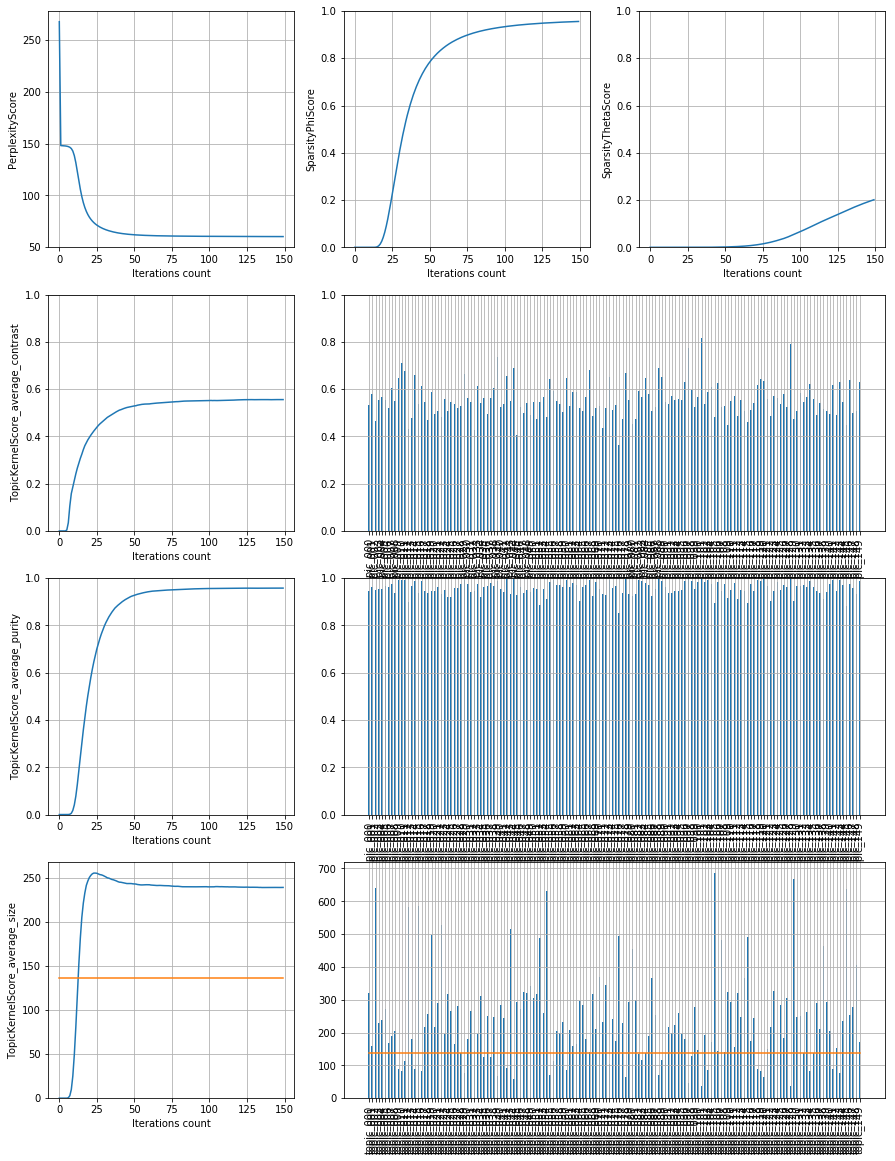

PerplexityScore: 60.29219055175781
SparsityPhiScore: 0.9556199312210083
SparsityThetaScore: 0.20132096111774445

TopicKernelScore_average_contrast: 0.5557247400283813
TopicKernelScore_average_purity: 0.9581460356712341
TopicKernelScore_average_size: 239.16000366210938

TopTokensScore:
topic_000: использовать использоваться анализ зависимость обладать вещество алкоголь метод лаборатория воздействие 
topic_001: пост возглавлять полномочие отставка собрание действующий обязанность дума спикер кандидатура 
topic_002: почему подходить узнавать правда совсем заставлять слишком голова глаз впрочем 
topic_003: франция нынешний французский степень париж перевод значимый преддверие платежный француз 
topic_004: турция огромный америка потерять опасность турецкий проявлять соседний активность вулкан 
topic_005: владивосток вертолет море поиск морской корабль флот приморье приморский гора 
topic_006: выражать характер обсуждение надежда делегация посол парламентский сессия обязательство дискуссия 

topic_078: определять существовать форма менее полагать например сохранять связанный вариант определенный 
topic_079: сезон этап четвертый кубок гонка стартовать бразилия старт шестой австралия 
topic_080: снимать написать картина герой анна спустя любовь лебедев съемка сюжет 
topic_081: кандидат голос голосование избирательный президентский избиратель кампания проголосовать справедливый набирать 
topic_082: заниматься позиция отвечать касаться опыт уверенный елена действительно профессиональный смысл 
topic_083: округ обеспечение дополнительный выделять совещание финансирование субъект муниципальный поручать предоставление 
topic_084: уточнять предварительный проживать оперативный дагестан аварийный устанавливаться дома махачкала кавказ 
topic_085: законодательство административный штраф вступать постановление имущество норма исполнение правовой юридический 
topic_086: интернет сеть электронный пользователь доступ карта сервис ресурс мобильный реклама 
topic_087: молодой организатор с

In [7]:
# Создание базовой пустой модели
model_artm = new_default_model(params['topic_count'], dictionary)

# Модель 0_0
# Запуск регуляризатора SparsePhi

# Обучение модели
model_artm.fit_offline(batch_vectorizer=batch_vectorizer, num_collection_passes=150)

# Вывод метрик модели
model_print_results(model_artm)

# Сохранение модели
model_artm.save("news_model_0_0")
model_artm_0_0 = model_artm.clone()

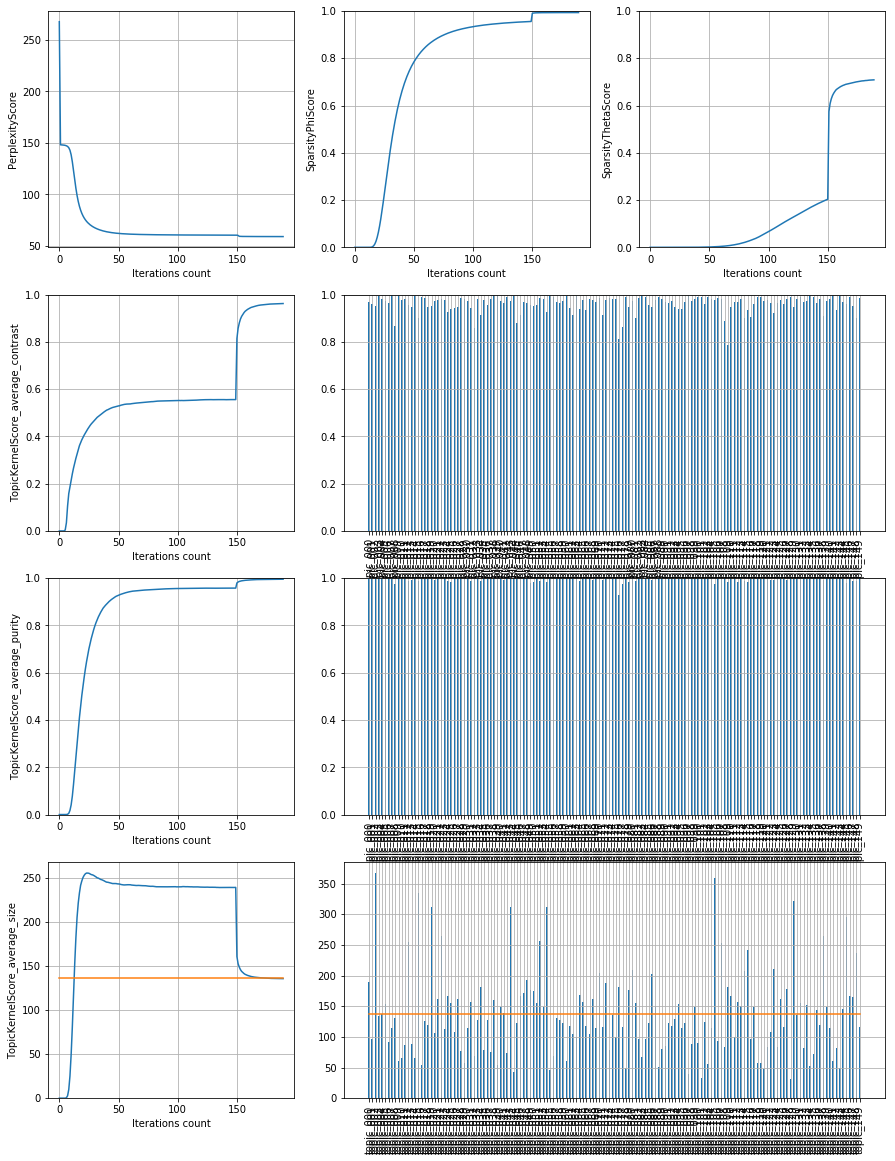

PerplexityScore: 58.93328857421875
SparsityPhiScore: 0.9932708144187927
SparsityThetaScore: 0.7085825204849243

TopicKernelScore_average_contrast: 0.9621503949165344
TopicKernelScore_average_purity: 0.9957592487335205
TopicKernelScore_average_size: 135.65333557128906

TopTokensScore:
topic_000: использовать использоваться анализ зависимость обладать вещество алкоголь метод здоровый лист 
topic_001: пост возглавлять полномочие отставка собрание действующий обязанность дума спикер кандидатура 
topic_002: почему узнавать правда подходить совсем глаз заставлять впрочем голова слишком 
topic_003: франция нынешний французский степень париж перевод значимый преддверие француз платежный 
topic_004: турция огромный америка опасность потерять турецкий соседний активность проявлять африка 
topic_005: владивосток вертолет море поиск морской корабль флот приморье гора приморский 
topic_006: выражать обсуждение характер надежда делегация посол обязательство сессия парламентский дискуссия 
topic_007:

topic_078: определять существовать форма менее полагать например сохранять связанный вариант определенный 
topic_079: сезон этап четвертый гонка стартовать кубок старт бразилия австралия шестой 
topic_080: снимать написать картина герой анна спустя любовь лебедев съемка сюжет 
topic_081: кандидат голос голосование президентский избирательный избиратель кампания проголосовать оппозиционный демократический 
topic_082: заниматься позиция отвечать касаться опыт уверенный елена действительно профессиональный смысл 
topic_083: округ обеспечение дополнительный выделять совещание финансирование субъект муниципальный поручать предоставление 
topic_084: уточнять предварительный проживать оперативный аварийный дагестан устанавливаться дома махачкала кавказ 
topic_085: законодательство административный вступать штраф постановление зарегистрировать норма имущество исполнение правовой 
topic_086: интернет сеть электронный пользователь ресурс карта доступ сервис мобильный реклама 
topic_087: молодой 

In [8]:
# Модель 0_1
# Запуск регуляризатора SparsePhi

# Загрузка модели
model_artm = model_artm_0_0.clone()

# Регуляризатор SparsePhi
# Создание регуляризатора, если он уже не создан
if params['SparsePhi']['name'] not in list(model_artm.regularizers.data):
    model_artm.regularizers.add(artm.SmoothSparsePhiRegularizer(name=params['SparsePhi']['name']))
# Настройка регуляризатора
model_artm.regularizers[params['SparsePhi']['name']].tau = params['SparsePhi']['tau']

# Обучение модели
model_artm.fit_offline(batch_vectorizer=batch_vectorizer, num_collection_passes=params['num_collection_passes'])

# Вывод метрик модели
model_print_results(model_artm)

# Сохранение модели
model_artm.save("news_model_0_1")
model_artm_0_1 = model_artm.clone()

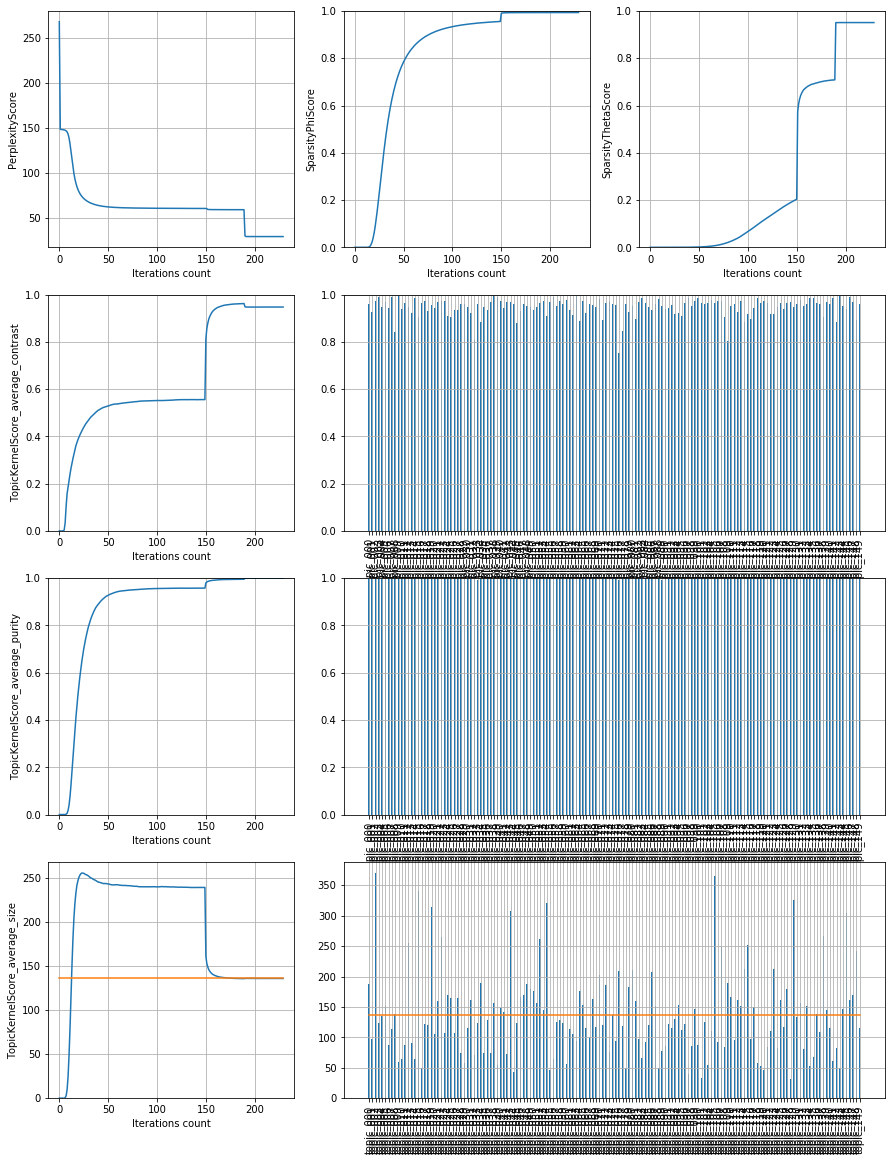

PerplexityScore: 29.114910125732422
SparsityPhiScore: 0.9933603405952454
SparsityThetaScore: 0.9509435296058655

TopicKernelScore_average_contrast: 0.9473696947097778
TopicKernelScore_average_purity: 0.9997896552085876
TopicKernelScore_average_size: 135.85333251953125

TopTokensScore:
topic_000: использовать алкоголь вещество использоваться метод анализ зависимость организм курение алкогольный 
topic_001: пост отставка полномочие возглавлять собрание обязанность кандидатура спикер дума должность 
topic_002: почему попадать правда маленький совсем впрочем узнавать глаз редакция никогда 
topic_003: франция французский париж нынешний перевод степень платежный саркозить француз олланд 
topic_004: турция турецкий вулкан аргентина америка ирландия анкара извержение чили пепел 
topic_005: владивосток вертолет морской корабль море флот приморье поиск приморский лодка 
topic_006: посол сессия парламентский обсуждение выражать делегация ассамблея литва характер пасе 
topic_007: новосибирск облас

topic_079: сезон этап гонка кубок четвертый пятый бразилия стартовать формула австралия 
topic_080: картина снимать герой лебедев любовь ходорковский съемка анна лента прокат 
topic_081: кандидат избирательный голосование голос избиратель президентский кампания проголосовать участвовать парламентский 
topic_082: позиция заниматься отвечать опыт касаться уверенный действительно смысл насколько профессиональный 
topic_083: округ обеспечение совещание дополнительный субъект выделять финансирование муниципальный поручать предоставление 
topic_084: дагестан махачкала аварийный предварительный уточнять оперативный тульский тула проживать кавказ 
topic_085: законодательство требование штраф административный постановление кодекс норма юридический вступать правовой 
topic_086: интернет сеть пользователь электронный сервис карта доступ мобильный устройство реклама 
topic_087: молодой организатор звезда собирать молодежный благотворительный мода бренд светлана дизайнер 
topic_088: средний мало ли

In [9]:
# Модель 0_2
# Запуск регуляризатора SparseTheta к уже включенному SparsePhi

# Загрузка модели
model_artm = model_artm_0_1.clone()

# Регуляризатор SparsePhi
# Создание регуляризатора если он уже не создан
if params['SparsePhi']['name'] not in list(model_artm.regularizers.data):
    model_artm.regularizers.add(artm.SmoothSparsePhiRegularizer(name=params['SparsePhi']['name']))
# Настройка регуляризатора
model_artm.regularizers[params['SparsePhi']['name']].tau = params['SparsePhi']['tau']

# Регуляризатор SparseTheta
# Создание регуляризатора если он уже не создан
if params['SparseTheta']['name'] not in list(model_artm.regularizers.data):
    model_artm.regularizers.add(artm.SmoothSparseThetaRegularizer(name=params['SparseTheta']['name']))
# Настройка регуляризатора
model_artm.regularizers[params['SparseTheta']['name']].tau = params['SparseTheta']['tau']

# Обучение модели
model_artm.fit_offline(batch_vectorizer=batch_vectorizer, num_collection_passes=params['num_collection_passes'])

# Вывод метрик модели
model_print_results(model_artm)

# Сохранение модели
model_artm.save("news_model_0_2")
model_artm_0_2 = model_artm.clone()

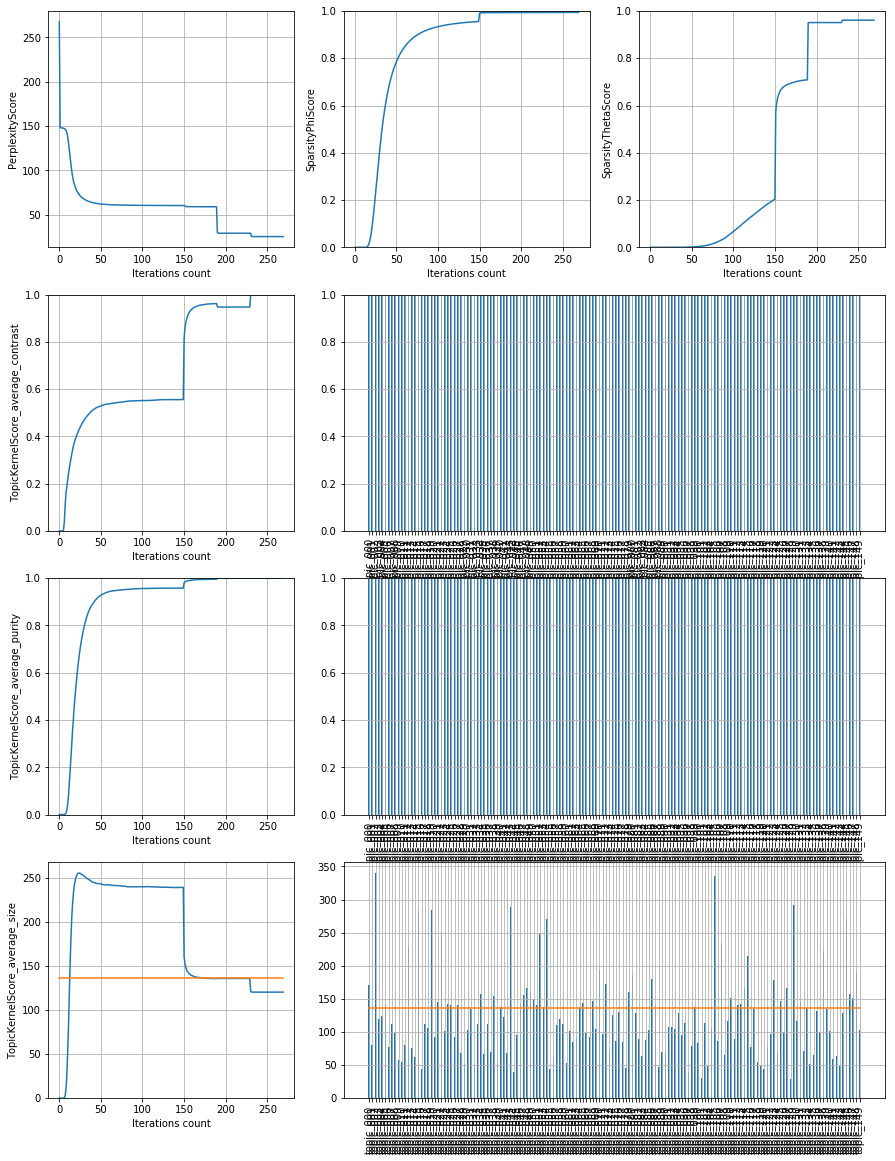

PerplexityScore: 25.334705352783203
SparsityPhiScore: 0.9941214919090271
SparsityThetaScore: 0.9611230492591858

TopicKernelScore_average_contrast: 1.0
TopicKernelScore_average_purity: 1.0
TopicKernelScore_average_size: 120.33333587646484

TopTokensScore:
topic_000: использовать алкоголь использоваться метод курение организм зависимость анализ пиво воздействие 
topic_001: пост полномочие возглавлять кандидатура спикер фракция обязанность избирать действующий досрочный 
topic_002: почему совсем впрочем узнавать слишком подходить совпадать выглядеть заставлять кстати 
topic_003: франция французский париж нынешний перевод степень платежный саркозить олланд мистраль 
topic_004: турция турецкий вулкан аргентина анкара ирландия извержение пепел чили стамбул 
topic_005: владивосток вертолет морской флот приморье поиск приморский гора подводный лодка 
topic_006: посол обсуждение делегация выражать литва пасе ассамблея надежда дискуссия характер 
topic_007: новосибирск областной новосибирский е

topic_079: сезон этап гонка четвертый бразилия стартовать формула австралия шестой петров 
topic_080: снимать лебедев ходорковский съемка анна лента сюжет юкос трейлер сниматься 
topic_081: кандидат избирательный голосование голос избиратель кампания проголосовать кпрф лдпр справедливый 
topic_082: позиция заниматься отвечать опыт касаться уверенный действительно смысл насколько многое 
topic_083: округ обеспечение совещание дополнительный субъект выделять финансирование муниципальный поручать поручение 
topic_084: дагестан махачкала предварительный аварийный уточнять тульский оперативный тула кавказ проживать 
topic_085: штраф административный законодательство постановление кодекс юридический вступать пристав обязывать правонарушение 
topic_086: интернет сеть пользователь электронный сервис карта доступ мобильный реклама приложение 
topic_087: молодой организатор звезда собирать молодежный благотворительный мода светлана дизайнер марафон 
topic_088: средний мало лишь примерно практиче

In [10]:
# Модель 0_3
# Запуск регуляризатора DecorrelatorPhi к уже включенным SparsePhi, SparseTheta

# Загрузка модели
model_artm = model_artm_0_2.clone()

# Регуляризатор SparsePhi
# Создание регуляризатора если он уже не создан
if params['SparsePhi']['name'] not in list(model_artm.regularizers.data):
    model_artm.regularizers.add(artm.SmoothSparsePhiRegularizer(name=params['SparsePhi']['name']))
# Настройка регуляризатора
model_artm.regularizers[params['SparsePhi']['name']].tau = params['SparsePhi']['tau']

# Регуляризатор SparseTheta
# Создание регуляризатора если он уже не создан
if params['SparseTheta']['name'] not in list(model_artm.regularizers.data):
    model_artm.regularizers.add(artm.SmoothSparseThetaRegularizer(name=params['SparseTheta']['name']))
# Настройка регуляризатора
model_artm.regularizers[params['SparseTheta']['name']].tau = params['SparseTheta']['tau']

# Регуляризатор DecorrelatorPhi
# Создание регуляризатора если он уже не создан
if params['DecorrelatorPhi']['name'] not in list(model_artm.regularizers.data):
    model_artm.regularizers.add(artm.DecorrelatorPhiRegularizer(name=params['DecorrelatorPhi']['name']))
# Настройка регуляризатора
model_artm.regularizers[params['DecorrelatorPhi']['name']].tau = params['DecorrelatorPhi']['tau']

# Обучение модели
model_artm.fit_offline(batch_vectorizer=batch_vectorizer, num_collection_passes=params['num_collection_passes'])

# Вывод метрик модели
model_print_results(model_artm)

# Сохранение модели
model_artm.save("news_model_0_3")
model_artm_0_3 = model_artm.clone()

In [11]:
phi = model_artm.phi_
phi

,topic_000,topic_001,topic_002,topic_003,topic_004,topic_005,topic_006,topic_007,topic_008,topic_009,...,topic_140,topic_141,topic_142,topic_143,topic_144,topic_145,topic_146,topic_147,topic_148,topic_149
карастелев,0.000000,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0000,0.000000,0.0,0.000000,0.0,0.0,0.0,0.0
гиббс,0.000000,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0000,0.000000,0.0,0.000000,0.0,0.0,0.0,0.0
холбрук,0.000000,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0000,0.000000,0.0,0.000000,0.0,0.0,0.0,0.0
тенге,0.000000,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0000,0.000000,0.0,0.000000,0.0,0.0,0.0,0.0
некляев,0.000000,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0000,0.000000,0.0,0.000000,0.0,0.0,0.0,0.0
змий,0.000000,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0000,0.000000,0.0,0.000000,0.0,0.0,0.0,0.0
летальность,0.000000,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0000,0.000000,0.0,0.000000,0.0,0.0,0.0,0.0
кровоточивость,0.000000,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0000,0.000000,0.0,0.000000,0.0,0.0,0.0,0.0
геморрагия,0.000000,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0000,0.000000,0.0,0.000000,0.0,0.0,0.0,0.0
касабланка,0.000000,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0000,0.000000,0.0,0.000000,0.0,0.0,0.0,0.0


In [12]:
theta = model_artm.get_theta()
theta

,2000,2001,2002,2003,2004,2005,2006,2007,2008,2009,...,21990,21991,21992,21993,21994,21995,21996,21997,21998,21999
topic_000,3.823787e-10,1.747944e-01,0.000000e+00,0.000000e+00,2.856525e-14,1.030564e-05,2.710167e-16,2.179779e-03,2.654216e-02,3.963430e-13,...,1.367661e-03,2.160247e-02,0.000000e+00,0.000000e+00,1.130259e-03,3.458710e-04,0.000000e+00,3.181263e-11,1.753370e-02,5.911176e-02
topic_001,1.178833e-01,0.000000e+00,0.000000e+00,5.809401e-14,1.184708e-15,4.476392e-16,2.533989e-02,1.030049e-02,8.473148e-05,2.271157e-10,...,3.118297e-14,1.516341e-02,1.607945e-02,0.000000e+00,3.540803e-04,0.000000e+00,1.068922e-03,8.813901e-02,0.000000e+00,0.000000e+00
topic_002,1.426343e-02,1.672093e-09,2.118600e-05,1.401517e-10,6.687646e-13,6.985547e-03,3.898236e-03,4.062573e-07,1.007007e-02,6.031414e-07,...,3.240571e-05,2.066460e-02,7.936728e-13,0.000000e+00,1.874872e-12,6.739987e-10,0.000000e+00,0.000000e+00,3.793804e-05,1.328304e-02
topic_003,4.007751e-02,0.000000e+00,0.000000e+00,2.514680e-15,0.000000e+00,0.000000e+00,1.227321e-11,9.570867e-03,1.426082e-02,3.468585e-02,...,8.547014e-03,2.300298e-05,1.939051e-16,0.000000e+00,0.000000e+00,1.523980e-13,8.347047e-14,3.099928e-02,0.000000e+00,1.040471e-14
topic_004,2.000723e-04,2.122410e-03,1.946480e-12,0.000000e+00,1.122851e-01,1.680690e-04,4.723858e-06,1.178547e-04,1.266872e-03,2.459691e-03,...,0.000000e+00,0.000000e+00,6.893702e-07,2.402399e-07,1.113697e-02,1.355326e-04,0.000000e+00,4.889582e-15,3.271241e-04,8.658557e-05
topic_005,2.932723e-04,0.000000e+00,0.000000e+00,1.127178e-01,1.033079e-01,0.000000e+00,0.000000e+00,6.017147e-04,0.000000e+00,0.000000e+00,...,1.096420e-05,5.438632e-04,1.212648e-08,2.561751e-04,9.250353e-05,0.000000e+00,0.000000e+00,4.936810e-04,0.000000e+00,3.408959e-06
topic_006,1.527698e-09,2.004795e-04,0.000000e+00,0.000000e+00,1.084207e-05,3.161903e-13,3.276190e-02,9.362036e-03,1.668535e-04,3.430196e-02,...,1.511360e-03,4.140942e-04,4.968791e-16,1.855998e-07,2.130917e-02,1.694915e-02,1.646380e-09,0.000000e+00,2.291893e-04,0.000000e+00
topic_007,5.683335e-05,0.000000e+00,1.301144e-01,0.000000e+00,1.823409e-02,0.000000e+00,5.980615e-16,1.941740e-02,4.266792e-04,0.000000e+00,...,0.000000e+00,5.066289e-08,6.577097e-15,3.784406e-03,1.065028e-04,0.000000e+00,0.000000e+00,0.000000e+00,4.217367e-04,4.389464e-11
topic_008,9.215496e-03,0.000000e+00,1.597492e-03,2.051645e-02,0.000000e+00,9.179434e-04,6.723867e-03,8.238398e-03,4.231846e-02,0.000000e+00,...,4.201974e-07,2.497328e-04,4.840175e-02,1.302451e-05,0.000000e+00,1.135737e-03,8.428737e-04,2.891946e-06,1.701576e-03,0.000000e+00
topic_009,1.466911e-15,0.000000e+00,2.467942e-02,1.381203e-02,3.166618e-02,1.405169e-02,4.779166e-14,2.221914e-13,3.693715e-10,2.507687e-16,...,0.000000e+00,5.382667e-04,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,9.242691e-12,0.000000e+00
